# `Step-by-step CNN Image Classification Pipeline`

In [1]:
#Importing libraries 

import warnings
import  os 
from PIL import Image 
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential 
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Dense,Conv2D, MaxPooling2D,Flatten
from tensorflow.keras.preprocessing import image_dataset_from_directory

warnings.filterwarnings("ignore")


2025-07-24 22:34:52.822562: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753396493.002273      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753396493.056899      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# `DATA CLEANING AND PREPROCESSING`

In [2]:

# Clean and Convert Images to RGB
def clean_and_convert(input_dir, output_dir="converted_dataset", valid_ext=(".jpg", ".jpeg", ".png")):
    converted = 0
    removed = 0
    valid_exts = [ext.lower() for ext in valid_ext]

    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        output_class_path = os.path.join("/kaggle/working", output_dir, class_name)
        os.makedirs(output_class_path, exist_ok=True)

        for file in os.listdir(class_path):
            input_path = os.path.join(class_path, file)
            if os.path.splitext(file)[1].lower() not in valid_exts:
                continue

            try:
                img = Image.open(input_path)
                rgb_img = img.convert("RGB")
                output_path = os.path.join(output_class_path, file)
                rgb_img.save(output_path)
                converted += 1
            except Exception as e:
                print(f"Skipping corrupt image: {input_path} -> {e}")
                removed += 1

    print(f"\u2705 Total Converted: {converted}")
    print(f"\U0001f5d1\ufe0f Total Skipped: {removed}")


In [3]:
# Define Dataset Paths
input_dir = "/kaggle/input/microsoft-catsvsdogs-dataset/PetImages"
clean_and_convert(input_dir)
cleaned_path = "/kaggle/working/converted_dataset"

Skipping corrupt image: /kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/11702.jpg -> cannot identify image file '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/11702.jpg'
Skipping corrupt image: /kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat/666.jpg -> cannot identify image file '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat/666.jpg'
✅ Total Converted: 24998
🗑️ Total Skipped: 2


In [4]:
# Load Image Dataset with Validation Split
train_ds = image_dataset_from_directory(
    cleaned_path,
    image_size=(128, 128),
    batch_size=32,
    validation_split=0.2,
    seed=123,
    subset="training"
)

val_ds = image_dataset_from_directory(
    cleaned_path,
    image_size=(128, 128),
    batch_size=32,
    validation_split=0.2,
    seed=123,
    subset="validation"
)

class_names = train_ds.class_names
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 24998 files belonging to 2 classes.
Using 19999 files for training.


2025-07-24 22:38:16.310223: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 24998 files belonging to 2 classes.
Using 4999 files for validation.


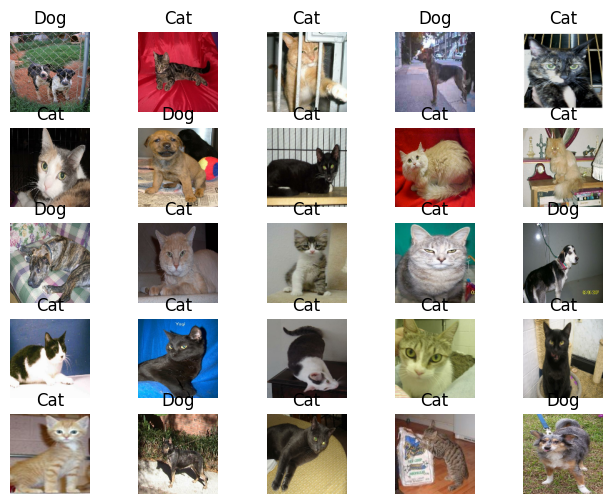

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,516,289 (24.86 MB)

 Trainable params: 6,516,289 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 222s 352ms/step - accuracy: 0.5610 - loss: 0.6840 - val_accuracy: 0.6571 - val_loss: 0.6094
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 217s 348ms/step - accuracy: 0.7245 - loss: 0.5377 - val_accuracy: 0.7848 - val_loss: 0.4541
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 217s 348ms/step - accuracy: 0.7930 - loss: 0.4415 - val_accuracy: 0.8064 - val_loss: 0.4160
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 218s 349ms/step - accuracy: 0.8319 - loss: 0.3701 - val_accuracy: 0.8158 - val_loss: 0.4105
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 216s 345ms/step - accuracy: 0.8664 - loss: 0.3042 - val_accuracy: 0.8260 - val_loss: 0.3840
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 263s 346ms/step - accuracy: 0.9003 - loss: 0.2410 - val_accuracy: 0.8340 - val_loss: 0.3949
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 221s 354ms/step - accuracy: 0.9331 - loss: 0.1703 - val_accuracy: 0.8046 - val_loss: 0.5791
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 217s 347ms/step - accuracy: 0.9540 -

In [5]:
# Visualize Sample Images
plt.figure(figsize=(8, 6))
for image_batch, label_batch in train_ds.take(1):
    for i in range(min(25, len(image_batch))):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
plt.show()

#Define the CNN Model
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # for binary classification
])

# Compile and Train the Model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

# Evaluate Model on Validation Set
loss, accuracy = model.evaluate(val_ds)
print(f"\n\u2705 Validation Accuracy: {accuracy:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


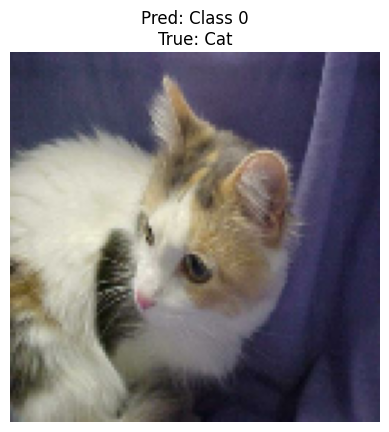

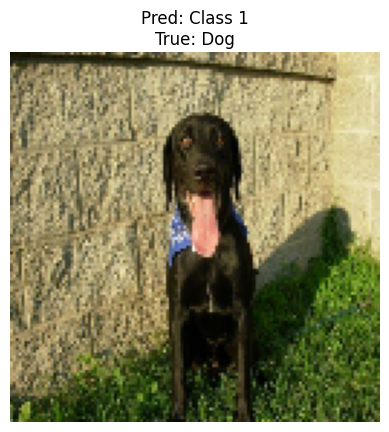

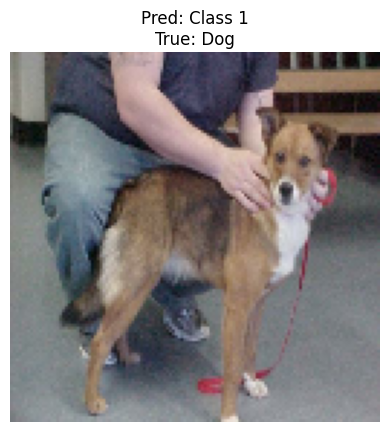

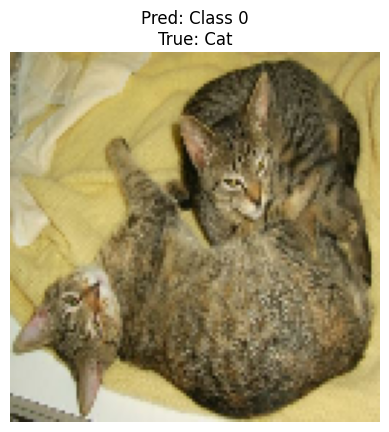

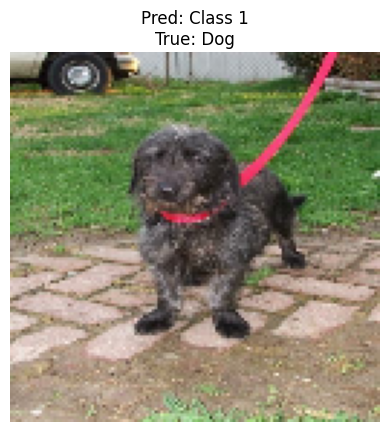

In [6]:
# Predict on Sample Batch
for image_batch, label_batch in val_ds.take(1):
    predictions = model.predict(image_batch)
    for i in range(5):
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(f"Pred: {'Class 1' if predictions[i] > 0.5 else 'Class 0'}\nTrue: {class_names[label_batch[i]]}")
        plt.axis("off")
        plt.show()

## Where Cat Label = 0   and the Dog label = 1

# ~THE END~